In [42]:
import pandas as pd
import json
import os
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import hdbscan
import matplotlib.pyplot as plt
import umap
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
DATA_DIR = '../../Hikki_comments'
FILENAME = 'result.json'

In [3]:
with open(os.path.join(DATA_DIR, FILENAME), 'r', encoding = 'utf-8') as f:
    data_json = json.load(f)

In [4]:
data_df = pd.DataFrame(data_json["messages"])

In [52]:
data_df["text_length"] = data_df["text"].apply(len)
data_df["text_type"] = data_df["text"].apply(lambda x: type(x).__name__)


In [53]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498902 entries, 0 to 498901
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    498902 non-null  int64  
 1   type                  498902 non-null  object 
 2   date                  498902 non-null  object 
 3   from                  487746 non-null  object 
 4   from_id               498056 non-null  object 
 5   file                  56104 non-null   object 
 6   thumbnail             53229 non-null   object 
 7   media_type            55924 non-null   object 
 8   sticker_emoji         46950 non-null   object 
 9   width                 73805 non-null   float64
 10  height                73805 non-null   float64
 11  text                  498902 non-null  object 
 12  reply_to_message_id   221181 non-null  float64
 13  photo                 18628 non-null   object 
 14  forwarded_from        6806 non-null    object 
 15  

In [54]:
data_df.head()

,id,type,date,from,from_id,file,thumbnail,media_type,sticker_emoji,width,...,via_bot,duration,game_title,game_description,game_link,game_message_id,score,location_information,text_length,text_type
0,1500015,message,2021-10-16T08:03:37,Mr. Half,user1328242587,(File not included. Change data exporting sett...,(File not included. Change data exporting sett...,sticker,🐱,512.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,str
1,1500016,message,2021-10-16T08:03:47,Mr. Half,user1328242587,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,str
2,1500017,message,2021-10-16T08:06:49,Mr. Half,user1328242587,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,167,str
3,1500018,message,2021-10-16T08:06:53,Mr. Half,user1328242587,(File not included. Change data exporting sett...,(File not included. Change data exporting sett...,sticker,😊,512.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,str
4,1500020,message,2021-10-16T08:15:30,ulees,user170252572,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,str


In [55]:
data_df_no_empty_messages = data_df[data_df["text_length"]>10][data_df["text_type"]=="str"].sample(20000).reset_index()

C:\Users\Alisa\AppData\Local\Temp\ipykernel_28164\2270397110.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_df_no_empty_messages = data_df[data_df["text_length"]>10][data_df["text_type"]=="str"].sample(20000).reset_index()


In [56]:
data_df_no_empty_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 20000 non-null  int64  
 1   id                    20000 non-null  int64  
 2   type                  20000 non-null  object 
 3   date                  20000 non-null  object 
 4   from                  19597 non-null  object 
 5   from_id               20000 non-null  object 
 6   file                  44 non-null     object 
 7   thumbnail             42 non-null     object 
 8   media_type            43 non-null     object 
 9   sticker_emoji         0 non-null      object 
 10  width                 357 non-null    float64
 11  height                357 non-null    float64
 12  text                  20000 non-null  object 
 13  reply_to_message_id   9693 non-null   float64
 14  photo                 315 non-null    object 
 15  forwarded_from     

In [57]:
data_df_no_empty_messages.head()

,index,id,type,date,from,from_id,file,thumbnail,media_type,sticker_emoji,...,via_bot,duration,game_title,game_description,game_link,game_message_id,score,location_information,text_length,text_type
0,106131,1743940,message,2022-01-03T23:44:55,Nevians [Лиса],user1455446790,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,str
1,368400,2119121,message,2022-05-12T00:13:26,Commissar,user897170917,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,str
2,108620,1748907,message,2022-01-05T16:28:17,dies irae,user609024228,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38,str
3,217036,1908725,message,2022-03-08T18:10:15,dies irae,user609024228,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,str
4,382245,2136795,message,2022-05-15T11:17:05,Damien,user894077793,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,str


In [58]:
data_df_no_empty_messages["text"]

0                            Там все правильно нарисовано.
1                     Фига ты уверенный воин, моё уважение
2                   ты думаешь, два в одном не может быть?
3                                            зацените воду
4                                 а что, Евровидение было?
                               ...                        
19995                            а это точно так работает?
19996                                         Тоже коняшка
19997                   то чачен не ходил бы с библиотекой
19998                             Оу ..тема \nЖизненная:((
19999    Ну, я там за 2,5 года аж раза три четыре навер...
Name: text, Length: 20000, dtype: object

In [59]:

model = SentenceTransformer('distiluse-base-multilingual-cased-v1')

In [60]:
embeddings = model.encode(data_df_no_empty_messages["text"], show_progress_bar=True)

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

In [61]:
len(data_df_no_empty_messages["text"])

20000

In [ ]:
pca = PCA(n_components=5)
pca_embeddings = pca.fit_transform(embeddings)

In [ ]:
print ( "Components = ", pca.n_components_ , ";\nTotal explained variance = ",
      round(pca.explained_variance_ratio_.sum(),5)  )

In [ ]:
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',
                          cluster_selection_method='eom').fit(pca_embeddings)


In [ ]:
pca_xy = PCA(n_components=2)
pca_embeddings_xy = pca_xy.fit_transform(embeddings)
result = pd.DataFrame(pca_embeddings_xy, columns=['x', 'y'])
result['labels'] = cluster.labels_

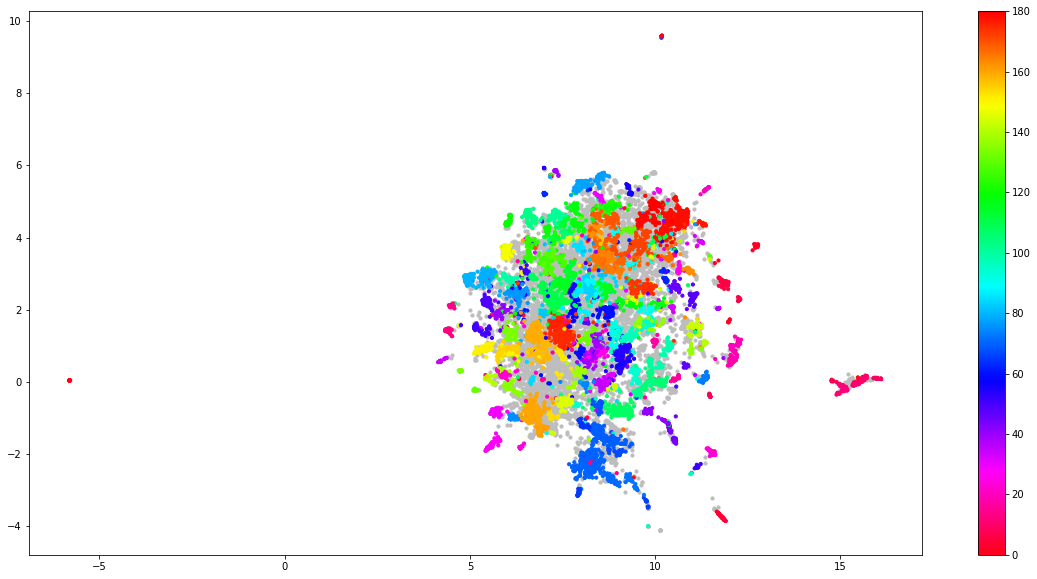

In [62]:

fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=10)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=10, cmap='hsv_r')
plt.colorbar()

In [63]:

umap_embeddings = umap.UMAP(n_neighbors=15,
                            n_components=5,
                            metric='cosine').fit_transform(embeddings)

In [64]:
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',
                          cluster_selection_method='eom').fit(umap_embeddings)

In [65]:
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

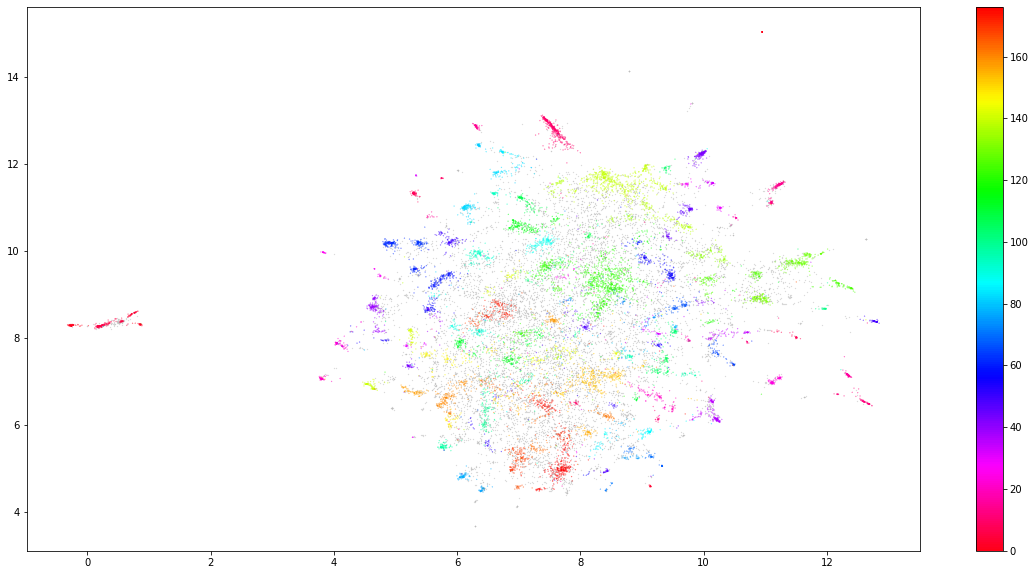

In [66]:
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [67]:
docs_df = pd.DataFrame(data_df_no_empty_messages["text"].values, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})





In [68]:

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data_df_no_empty_messages))

In [69]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

C:\ProgramData\Anaconda3\envs\text_clusterisation_code\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
0,-1,8960
122,121,706
140,139,569
11,10,365
154,153,288
177,176,247
130,129,194
43,42,162
89,88,144
123,122,143


In [70]:
top_n_words[121][:10]

[('меня', 0.1850892925057198),
 ('мне', 0.07964526011020186),
 ('на', 0.044778795012039116),
 ('тоже', 0.04410645300541988),
 ('так', 0.03740638586078547),
 ('есть', 0.03665743629540829),
 ('это', 0.03461985803236366),
 ('мой', 0.028778809492273044),
 ('вот', 0.027303982730820308),
 ('как', 0.026353073354712115)]

In [71]:
top_n_words[139][:10]

[('что', 0.049543063161709255),
 ('не', 0.0472459212303918),
 ('то', 0.03699565595435323),
 ('это', 0.034128112401811954),
 ('но', 0.026035858402883357),
 ('на', 0.02505422994197576),
 ('как', 0.02357731617894423),
 ('мне', 0.02247187138126942),
 ('если', 0.0221860057455103),
 ('меня', 0.02166281343148481)]

In [72]:
top_n_words[10][:10]

[('игра', 0.050252673690486596),
 ('игры', 0.04754225090002745),
 ('играть', 0.04244217490576773),
 ('на', 0.03780201274042101),
 ('что', 0.03329106746390321),
 ('не', 0.031996110817625),
 ('игру', 0.03134392156896464),
 ('то', 0.02708907819463033),
 ('играл', 0.02622506291108582),
 ('это', 0.026054856568617415)]

In [73]:
top_n_words[153][:10]

[('потом', 0.20012121814601794),
 ('тогда', 0.07124256061094349),
 ('после', 0.06292819156484783),
 ('ещё', 0.05673516713934761),
 ('он', 0.0460525595190964),
 ('так', 0.04129434507119287),
 ('бим', 0.03116996593381972),
 ('началось', 0.030353338115652436),
 ('уже', 0.02929612143217547),
 ('она', 0.02854236402876186)]

In [74]:
top_n_words[176][:10]

[('койл', 0.08553667574665806),
 ('ебучие', 0.04642289242812663),
 ('шоб', 0.04195559263698145),
 ('бан', 0.038301038082183846),
 ('пиздец', 0.038065737664702906),
 ('нахуй', 0.03731717189737461),
 ('ща', 0.0342827249782459),
 ('кста', 0.03346997974189832),
 ('зайчик', 0.03237377986634862),
 ('сука', 0.03148503648406926)]

In [75]:
top_n_words[129][:10]

[('спать', 0.2181744834582101),
 ('сон', 0.08936077676390648),
 ('сне', 0.06602684102126247),
 ('проснулся', 0.06296635025480664),
 ('во', 0.05035830827520894),
 ('не', 0.04575105263737119),
 ('сны', 0.045299618488114764),
 ('как', 0.04513444437630828),
 ('поспать', 0.040069495616695136),
 ('кровати', 0.037587453714188125)]

In [76]:
top_n_words[42][:10]

[('помню', 0.18645308359897744),
 ('забыл', 0.08189433638276779),
 ('вспомнил', 0.07139428765099415),
 ('вспомнила', 0.0498296537794199),
 ('не', 0.0464317652451316),
 ('вспомнить', 0.04429302558170657),
 ('память', 0.041142635832548395),
 ('что', 0.039699011381387476),
 ('забыла', 0.03814670322129038),
 ('напомнили', 0.03676137514889409)]

In [42]:
top_n_words[31][:10]


[('сна', 0.010414627489009821),
 ('спать', 0.009146894358019535),
 ('сон', 0.007390956265822554),
 ('день', 0.006075362323822774),
 ('дня', 0.005342756124287023),
 ('устал', 0.004712424536556915),
 ('часов', 0.004459906115915411),
 ('сном', 0.0043834685346518095),
 ('сны', 0.004309841257835951),
 ('ночью', 0.004208776962273514)]

In [43]:
top_n_words[16][:10]

[('bioware', 0.015436111495710263),
 ('июня', 0.01309162374443515),
 ('игра', 0.012229734689072617),
 ('игры', 0.011598762684486487),
 ('age', 0.010571546417578483),
 ('00', 0.010456720690642437),
 ('dragon', 0.010333569069615465),
 ('мск', 0.010287417159139353),
 ('разработчики', 0.009675040650907164),
 ('games', 0.009087058915016226)]